In [169]:
import pandas
import numpy
import itertools
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
import networkx as nx
from sknetwork.clustering import Louvain, modularity, bimodularity
from scipy.stats import ttest_ind
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go

In [170]:
amal_to_allen = {
    'Amy':['LA','BLA','BMA','PA','sAMY'],
    'ARC':'ARH',
    'CER':'CB',
    'DMH':'DMH',
    'HAB':['MH','LH'],
    'Hipp':'HIP',
    'LGP':'GPe',
    'LH':'LHA',
    'MGP':'GPi',
    'MMB':'MBO',
    'Olb':'MOB',
    'PON':'P',
    'PRA':['LPO','MPO'],
    'PRC':['ILA','PL','ORB'],
    'PUT':'CP',
    'PVN':'PVH',
    'SCN':'SCH',
    'SON':'SO',
    'SUN':['SNc','SNr'],
    'THA':'TH',
    'VIC':'VISp',
    'VMH':'VMH',
}

In [171]:
amal_names = {
    'Amy':'amygdala',
    'ARC':'arcuate nucleus',
    'CER':'cerebellum',
    'DMH':'dorsomedial hypothalamus',
    'HAB':'habenula',
    'Hipp':'hippocampus',
    'LGP':'lateral globus pallidus',
    'LH':'lateral hypothalamus',
    'MGP':'medial globus pallidus',
    'MMB':'mammilary body',
    'Olb':'olfactory bulb',
    'PON':'pons',
    'PRA':'preoptic area',
    'PRC':'prefrontal cortex',
    'PUT':'putamen',
    'PVN':'paraventricular nucleus',
    'SCN':'suprachiasmatic nucleus',
    'SON':'supraoptic nucleus',
    'SUN':'substantia nigrl',
    'THA':'thalamus',
    'VIC':'visual cortex',
    'VMH':'ventromedial hypothalamus',
}

In [172]:
allen_to_amal = {}

for k in amal_to_allen.keys():
    if isinstance(amal_to_allen[k], str):
        allen_to_amal[amal_to_allen[k]] = k
    else:
        for v in amal_to_allen[k]:
            allen_to_amal[v]=k

In [173]:
edge_df = pandas.read_csv("../data/ALLnormdensity_averages-primary.bab-20230425.csv",index_col=0)

In [174]:
for i,row in edge_df.iterrows():
    edge_df['source'][i] = allen_to_amal[edge_df.iloc[i].source]
    edge_df['target'][i] = allen_to_amal[edge_df.iloc[i].target]

In [175]:
edge_df = edge_df.loc[~edge_df['source'].isin(drop)]
edge_df = edge_df.loc[~edge_df['target'].isin(drop)]
regions = edge_df.source.unique()
edge_df.head()

,source,target,normalized_projection_density_source_average
0,ARC,Amy,0.000112
1,ARC,Amy,0.000250
2,ARC,CER,0.000015
3,ARC,PUT,0.000015
4,ARC,DMH,0.003601


In [176]:
new_edge_df = pandas.DataFrame(columns=['source','target','normalized_projection_density_source_average'])
for r1,r2 in itertools.permutations(regions,2):
    weight = edge_df.loc[(edge_df.source ==r1) & 
                         (edge_df.target ==r2)]['normalized_projection_density_source_average'].mean()
    new_edge_df = pandas.concat([new_edge_df,pandas.DataFrame([[r1,r2,weight]],columns=cols)])
edge_df = new_edge_df

In [177]:
edge_df = edge_df.loc[edge_df.normalized_projection_density_source_average != 0]
edge_df['log weight'] = numpy.log(edge_df['normalized_projection_density_source_average'])

In [178]:
drop=['cbf', 'mfbc', 'cc', 'cst', 'cm', 'dhc', 'eps', 'fiber tracts', 'mfsbshy', 'py', 'lfbst', 'vhc', 'VS', 'root']

In [179]:
len(regions)

22

In [180]:
node_input = regions

In [181]:
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json')
structure_tree = mcc.get_structure_tree()

In [182]:
allen_regions = [amal_to_allen[r] if isinstance(amal_to_allen[r],str) else amal_to_allen[r][0] for r in regions ]
regions_df = pandas.DataFrame(structure_tree.get_structures_by_acronym(allen_regions))[['acronym','name','id','rgb_triplet']]

In [183]:
regions_df['acronym'] = regions
regions_df['name'] = [amal_names[r] for r in regions]
regions_df

,acronym,name,id,rgb_triplet
0,ARC,arcuate nucleus,223,"[255, 93, 80]"
1,Amy,amygdala,131,"[144, 235, 141]"
2,CER,cerebellum,512,"[240, 240, 128]"
3,PUT,putamen,672,"[152, 214, 249]"
4,DMH,dorsomedial hypothalamus,830,"[255, 85, 71]"
5,LGP,lateral globus pallidus,1022,"[133, 153, 204]"
6,MGP,medial globus pallidus,1031,"[133, 153, 204]"
7,Hipp,hippocampus,1080,"[126, 208, 75]"
8,PRC,prefrontal cortex,44,"[89, 179, 99]"
9,HAB,habenula,483,"[255, 144, 159]"


<AxesSubplot:>

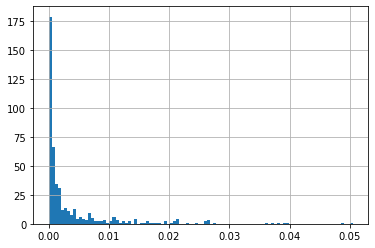

In [184]:
edge_df['normalized_projection_density_source_average'].hist(bins=100)

In [185]:
edge_df['log weight'].mean()

-7.315429436728489

In [186]:
G = nx.DiGraph()
#below define nodes from source
nodes=node_input
idx=list(range(0,len(nodes)))

#G.add_nodes_from(idx)
G.add_nodes_from(nodes)

top_percentile = 1
bottom_percentile = 75

zero=numpy.percentile(edge_df['log weight'], bottom_percentile) 
large=numpy.percentile(edge_df['log weight'], 100-top_percentile)-zero

#adds edges to G from the average normalized projection densities for each source -> target relationship
for (x,y) in itertools.product(node_input,node_input):
    query_df = edge_df.copy()
    query_df = query_df.loc[(query_df.source == x) & (query_df.target ==y)]
    if query_df.shape[0] == 0:
        continue
    elif query_df['log weight'].iloc[0] < zero:
        continue
    weight = query_df['log weight'].iloc[0]-zero
    G.add_edge(x,y,weight=weight)

In [187]:
zero

-5.668634874727582

In [188]:
zero=0
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > large]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if (d['weight'] <= large) & (d['weight'] > zero)]
ezero = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= zero]
enonzero = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > zero]
weights=[d['weight'] for (u, v, d) in G.edges(data=True) if d['weight'] > zero]

print('large is over '+str(large))
print('zero is below '+str(zero))
print(len(elarge))
print(len(esmall))
print(len(ezero))

large is over 2.386101328089353
zero is below 0
5
111
0


In [189]:
max_weight=numpy.max(weights)

edge_colors = [w/max_weight for w in weights]
edge_alphas = [w/max_weight for w in weights]

len(weights)

116

In [190]:
#pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning:

Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().



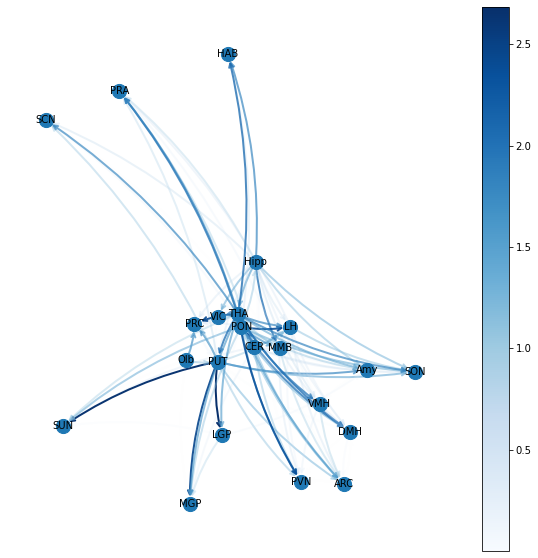

In [191]:
plt.figure(figsize=(10,10))
# nodes
nx.draw_networkx_nodes(G, pos, node_size=200)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif');

edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=10, width=2,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=plt.cm.Blues)

for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(weights)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
#plt.savefig("figures/allnodes-spring_layout_edges.svg")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning:

Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().



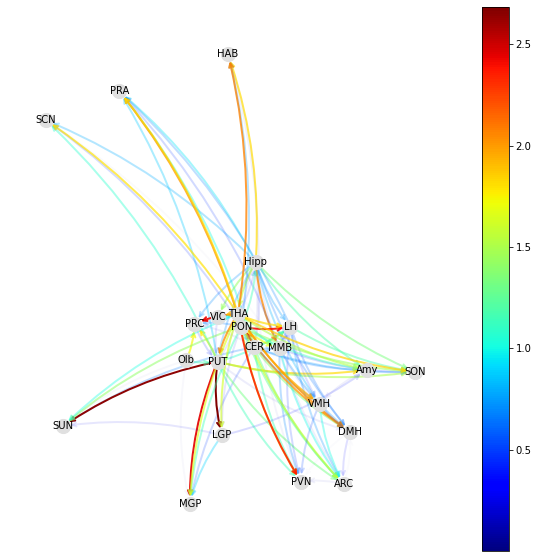

In [192]:
plt.figure(figsize=(10,10))

# nodes
nx.draw_networkx_nodes(G, pos, node_size=200,node_color='#E0E0E0')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=10, width=2,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=plt.cm.jet)

for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])
    
pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.jet)
pc.set_array(weights)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
#plt.savefig('figures/all_1.svg')
plt.show()

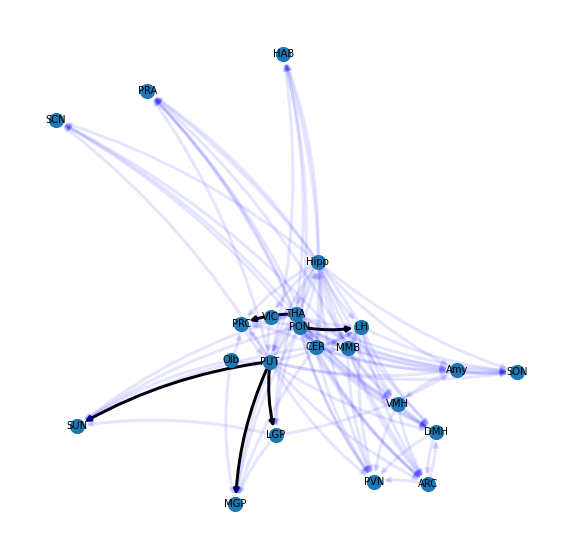

In [193]:
plt.figure(figsize=(10,10))
# nodes
nx.draw_networkx_nodes(G, pos, node_size=200)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=3, connectionstyle='arc3, rad=0.1')
nx.draw_networkx_edges(G, pos, edgelist=esmall,
                       width=3, alpha=0.1, edge_color='b',
                      connectionstyle='arc3, rad=0.1')

nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.axis('off')
#plt.savefig('figures/all_2.svg')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning:

Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().



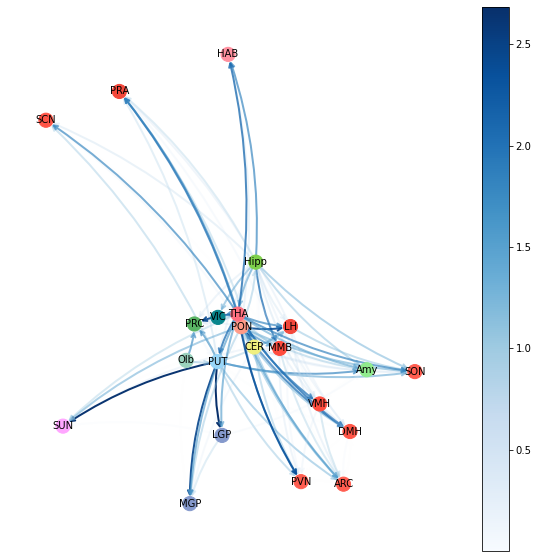

In [194]:
plt.figure(figsize=(10,10))

allen_colors = regions_df.rgb_triplet.values
# nodes
nx.draw_networkx_nodes(G, pos, node_size=200,node_color=[numpy.array(cl)/255 for cl in allen_colors])

# edges
edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=10, width=2,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=plt.cm.Blues)

for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(weights)
plt.colorbar(pc)

nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.axis('off')
#plt.savefig('figures/allen_coloring.svg')
plt.show()

In [195]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(numpy.linspace(minval, maxval, n)))
    return new_cmap

In [196]:
node_cen=nx.betweenness_centrality(G, k=None, normalized=True, weight='weight')
cen_scores=[]
for node in node_input:
    cen_scores.append(node_cen[node])

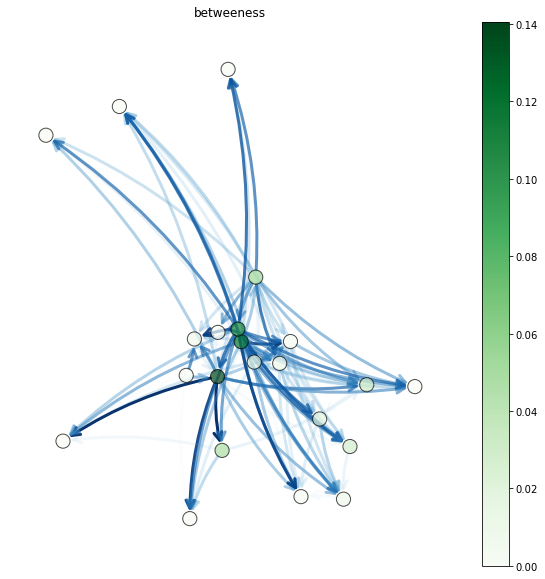

In [197]:
# color the nodes according to their partition
cmap = plt.cm.get_cmap('Greens')
#norm = colors.Normalize(vmin=min(btw_scores),vmax=max(btw_scores))
# edges
plt.figure(figsize=(10,10))
nodes = nx.draw_networkx_nodes(G, pos, node_size=200,
                       cmap=cmap, alpha=0.7,node_color=cen_scores)


edge_cmap=plt.cm.Blues

edge_cmap=truncate_colormap(edge_cmap, 0.4, 1)
edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=20, width=3,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=edge_cmap)
for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])
pc = mpl.collections.PatchCollection(edges, cmap=edge_cmap)
pc.set_array(weights)
#plt.colorbar(pc, orientation="horizontal", fraction=0.05)
#nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(cen_scores), vmax=max(cen_scores)))
plt.colorbar(sm)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
plt.axis('off')
plt.title('betweeness')
#plt.savefig('figures/betweenness.svg')
plt.show()

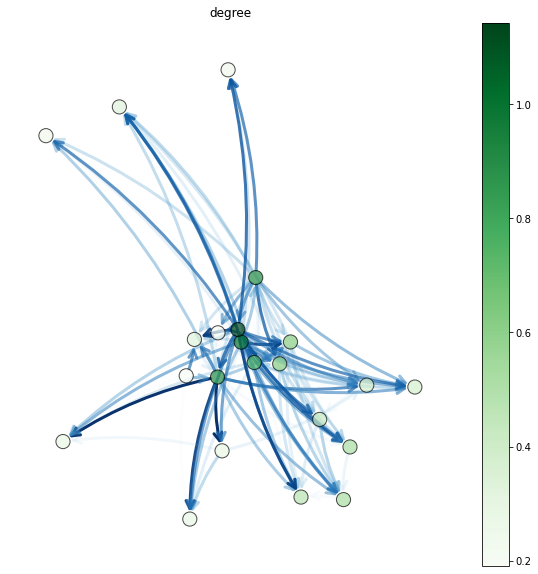

In [198]:
node_cen = nx.degree_centrality(G)
cen_scores=[]
for node in node_input:
    cen_scores.append(node_cen[node])
    
# color the nodes according to their partition
cmap = plt.cm.get_cmap('Greens')
#norm = colors.Normalize(vmin=min(btw_scores),vmax=max(btw_scores))
# edges
plt.figure(figsize=(10,10))
nodes = nx.draw_networkx_nodes(G, pos, node_size=200,
                       cmap=cmap, alpha=0.7,node_color=cen_scores)


edge_cmap=plt.cm.Blues

edge_cmap=truncate_colormap(edge_cmap, 0.4, 1)
edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=20, width=3,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=edge_cmap)
for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])
pc = mpl.collections.PatchCollection(edges, cmap=edge_cmap)
pc.set_array(weights)
#plt.colorbar(pc, orientation="horizontal", fraction=0.05)
#nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(cen_scores), vmax=max(cen_scores)))
plt.colorbar(sm)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
plt.axis('off')
plt.title('degree')
#plt.savefig('figures/degree.svg')
plt.show()

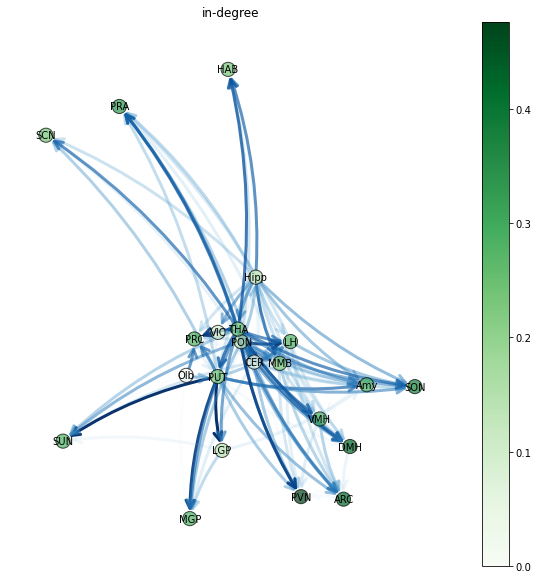

In [199]:
node_cen = nx.in_degree_centrality(G)
cen_scores=[]
for node in node_input:
    cen_scores.append(node_cen[node])
    
# color the nodes according to their partition
cmap = plt.cm.get_cmap('Greens')
#norm = colors.Normalize(vmin=min(btw_scores),vmax=max(btw_scores))
# edges
plt.figure(figsize=(10,10))
nodes = nx.draw_networkx_nodes(G, pos, node_size=200,
                       cmap=cmap, alpha=0.7,node_color=cen_scores)


edge_cmap=plt.cm.Blues

edge_cmap=truncate_colormap(edge_cmap, 0.4, 1)
edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=20, width=3,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=edge_cmap)
for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])
pc = mpl.collections.PatchCollection(edges, cmap=edge_cmap)
pc.set_array(weights)
#plt.colorbar(pc, orientation="horizontal", fraction=0.05)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(cen_scores), vmax=max(cen_scores)))
plt.colorbar(sm)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
plt.axis('off')
plt.title('in-degree')
#plt.savefig('figures/all_3.svg')
plt.show()

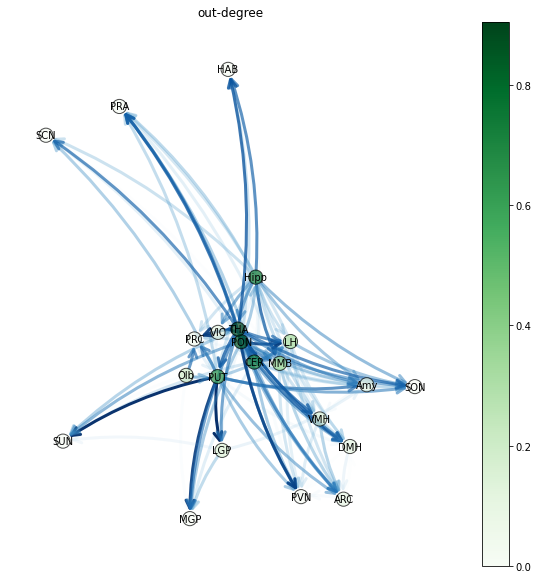

In [200]:
node_cen = nx.out_degree_centrality(G)
cen_scores=[]
for node in node_input:
    cen_scores.append(node_cen[node])
    
# color the nodes according to their partition
cmap = plt.cm.get_cmap('Greens')
#norm = colors.Normalize(vmin=min(btw_scores),vmax=max(btw_scores))
# edges
plt.figure(figsize=(10,10))
nodes = nx.draw_networkx_nodes(G, pos, node_size=200,
                       cmap=cmap, alpha=0.7,node_color=cen_scores)


edge_cmap=plt.cm.Blues

edge_cmap=truncate_colormap(edge_cmap, 0.4, 1)
edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=20, width=3,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=edge_cmap)
for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])
pc = mpl.collections.PatchCollection(edges, cmap=edge_cmap)
pc.set_array(weights)
#plt.colorbar(pc, orientation="horizontal", fraction=0.05)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(cen_scores), vmax=max(cen_scores)))
plt.colorbar(sm)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
plt.axis('off')
plt.title('out-degree')
#plt.savefig('figures/all_3.svg')
plt.show()

In [201]:
louvain = Louvain()
labels = louvain.fit_transform(nx.adjacency_matrix(G))
print(max(labels)+1)

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning:

Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().



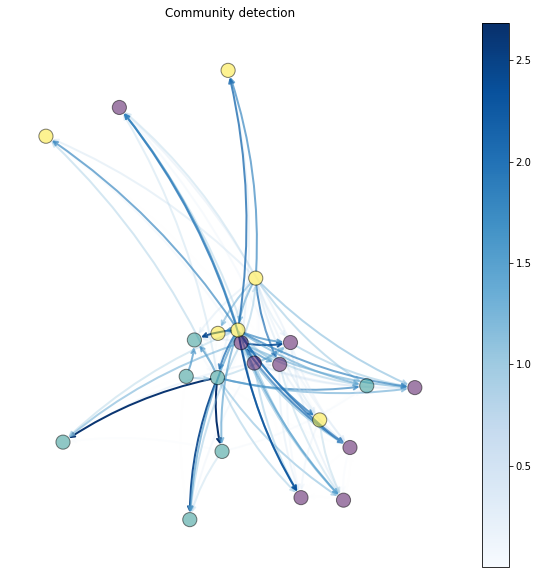

In [202]:
plt.figure(figsize=(10,10))

# nodes
cmap = cm.get_cmap('viridis', max(labels) + 1)
nx.draw_networkx_nodes(G, pos,  node_size=200,
                       cmap=cmap, alpha=0.5,node_color=labels)
#nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=10, width=2,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=plt.cm.Blues)

for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(weights)
plt.colorbar(pc)

plt.title('Community detection')
ax = plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_axis_off()
#plt.savefig("figures/louvain.svg")
plt.show()

In [203]:
for k in pos.keys():
    G.nodes[k]['pos']=pos[k]

In [204]:
print(len(enonzero))
print(len(esmall))
print(len(elarge))

116
111
5


In [205]:
for edge in elarge:
    #if (edge[0] not in aca_cluster) or (edge[1] not in aca_cluster):
    #    continue
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    if (numpy.abs(x0) > 0.4) or (numpy.abs(x1)>0.4) or (numpy.abs(y0)>0.4) or (numpy.abs(y1)>0.4):
        print(edge)

('PUT', 'MGP')
('PUT', 'SUN')


In [206]:
edge_x = []
edge_y = []
for edge in elarge:
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    #if (numpy.abs(x0) > 0.4) or (numpy.abs(x1)>0.4) or (numpy.abs(y0)>0.4) or (numpy.abs(y1)>0.4):
    #    print(edge)
    #    continue
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace1 = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.2, color='#888'),
    hoverinfo='none',
    mode='lines')

edge_x = []
edge_y = []
for edge in esmall:
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    #if (numpy.abs(x0) > 0.4) or (numpy.abs(x1)>0.4) or (numpy.abs(y0)>0.4) or (numpy.abs(y1)>0.4):
    #    print(edge)
    #    continue
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace2 = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.05, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        line_width=0.1,
        line_color='black'))


In [207]:
louvain = Louvain(resolution=1)
labels = louvain.fit_transform(nx.adjacency_matrix(G))
cluster_probs = louvain.membership_.todense()

node_cen = nx.betweenness_centrality(G, k=None, normalized=True, weight='weight')
#node_cen = nx.degree_centrality(G)

cen_scores=[]
for node in node_input:
    cen_scores.append(node_cen[node])

In [208]:
#node_trace.marker.color = labels
node_text = [f'{labels[i]+1}: {regions_df.name.values[i]}:</br></br> {cluster_probs[i]}' for i in range(len(cen_scores))]
node_text = [f'{labels[i]+1}: {regions_df.name.values[i]}' for i in range(len(cen_scores))]

node_size = (numpy.array(cen_scores)*30/max(cen_scores))+10

cmap="viridis"
cmap=plt.get_cmap(cmap)
colors = cmap(numpy.linspace(0, 1, max(labels)+1))
colors_hex=[mpl.colors.rgb2hex(l) for l in colors]

#colors = [numpy.array(cl)/255 for cl in allen_colors]
#colors_hex=[mpl.colors.rgb2hex(l) for l in colors]

In [209]:
colors_hex[2]="#eb4c34"

In [210]:
#rois = ['ACA','ATN','ILM','LAT','MED','MTN','VENT','CP','AI','AHN','SSp','AUDp','MOp']
#rois = ['ACA','ATN','ILM','CP']
rois=[]

cen = "Betweenness"

fig = go.Figure(data=[edge_trace1,edge_trace2],
             layout=go.Layout(
                title=f'Network Structure - Louvain Community Detection',
                titlefont_size=16,
                showlegend=True,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

for l in range(max(labels)+1):
        #if (l!=0):
        #    continue
        trace_node_x = numpy.array(node_x)[labels==l]
        trace_node_y = numpy.array(node_y)[labels==l]
        trace_text = [node_text[i] for i in range(len(node_x)) if labels[i]==l]
        trace_size = [node_size[i] for i in range(len(node_x)) if labels[i]==l]
        #trace_color = [colors_hex[i] for i in range(len(node_x)) if labels[i]==l]
        
        trace_color = colors_hex[l]
        fig.add_trace(go.Scatter(
            y=trace_node_y,
            x=trace_node_x,
            mode='markers',
            marker_color=trace_color,
            marker_size=trace_size,
            marker_opacity=0.5,
            text=trace_text,
            hoverinfo="text",
            marker_line_color='black',
            marker_line_width=0.1
        ))
        

for i,roi in enumerate(regions):
    roi_idx = list(node_input).index(roi)
    coord_x = node_x[roi_idx]
    coord_y = node_y[roi_idx]
    fig.add_annotation(x=coord_x, y=coord_y,
                        text=roi,
                        showarrow=False)


plotly.io.write_html(fig, file=f'figures/{cen}-louvain.html')
plotly.io.write_image(fig, file=f'figures/{cen}-louvain.png')
plotly.io.write_image(fig, file=f'figures/{cen}-louvain.svg')

fig.show()

In [214]:
connectivity_m = numpy.zeros((len(regions),len(regions)))

for i,r1 in enumerate(regions):
    for j,r2 in enumerate(regions):
        if i==j:
            weight=None
        else:
            weight = edge_df.loc[(edge_df.source==r1) & (edge_df.target==r2)]['log weight']
        connectivity_m[i][j]=weight
        
con_zero_m = connectivity_m - numpy.nanmin(connectivity_m)
con_scale_m = con_zero_m / numpy.nanmax(con_zero_m)

In [217]:
import seaborn as sns

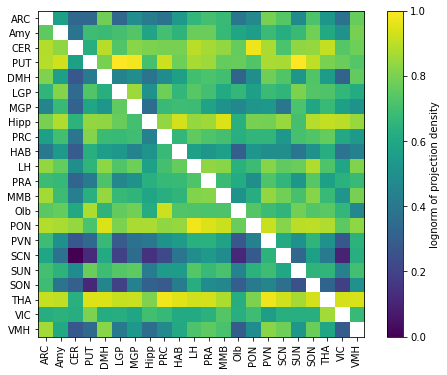

In [218]:
f,ax = plt.subplots(figsize=(8,6))
heatmap = ax.imshow(con_scale_m)
bar = plt.colorbar(heatmap)
bar.set_label("lognorm of projection density")
plt.xticks(list(range(len(regions))),regions,rotation='vertical');
plt.yticks(list(range(len(regions))),regions);

In [219]:
labels

array([0, 1, 0, 1, 0, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 2, 1, 0, 2, 2, 2],
      dtype=int64)

In [220]:
idx_order = []
for v in range(0,max(labels)+1):
    for i,l in enumerate(labels):
        if l==v:
            idx_order.append(i)

In [221]:
con_scale_m.shape

(22, 22)

In [222]:
regions[idx_order]

array(['ARC', 'CER', 'DMH', 'LH', 'PRA', 'MMB', 'PON', 'PVN', 'SON',
       'Amy', 'PUT', 'LGP', 'MGP', 'PRC', 'Olb', 'SUN', 'Hipp', 'HAB',
       'SCN', 'THA', 'VIC', 'VMH'], dtype=object)

In [223]:
import matplotlib.patches as patches

In [224]:
idx = numpy.empty_like(idx_order)
idx[idx_order] = numpy.arange(len(idx_order))
idx

array([ 0,  9,  1, 10,  2, 11, 12, 16, 13, 17,  3,  4,  5, 14,  6,  7, 18,
       15,  8, 19, 20, 21])

In [225]:
cluster_scale_m = con_scale_m[:,idx_order]
cluster_scale_m = cluster_scale_m[idx_order,:]

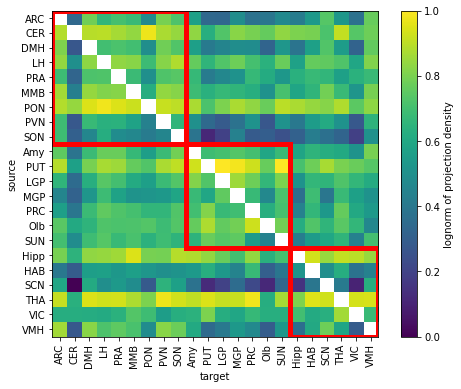

In [226]:
f,ax = plt.subplots(figsize=(8,6))
heatmap = ax.imshow(cluster_scale_m)
bar = plt.colorbar(heatmap)
bar.set_label("lognorm of projection density")
plt.xticks(list(range(len(regions))),regions[idx_order],rotation='vertical');
plt.yticks(list(range(len(regions))),regions[idx_order]);
plt.xlabel("target")
plt.ylabel("source")

startpoint = -0.5
for v in range(0,max(labels)+1):
    num = sum(labels==v)
    clust = patches.Rectangle((startpoint,startpoint),num,num, 
                              linewidth=5,edgecolor='r',facecolor='none')
    startpoint = startpoint + num
    ax.add_patch(clust)
plt.savefig("figures/connectivitymatrix.clustered.svg")
plt.savefig("figures/connectivitymatrix.clustered.png")

In [227]:
amal_to_allen

{'Amy': ['LA', 'BLA', 'BMA', 'PA', 'sAMY'],
 'ARC': 'ARH',
 'CER': 'CB',
 'DMH': 'DMH',
 'HAB': ['MH', 'LH'],
 'Hipp': 'HIP',
 'LGP': 'GPe',
 'LH': 'LHA',
 'MGP': 'GPi',
 'MMB': 'MBO',
 'Olb': 'MOB',
 'PON': 'P',
 'PRA': ['LPO', 'MPO'],
 'PRC': ['ILA', 'PL', 'ORB'],
 'PUT': 'CP',
 'PVN': 'PVH',
 'SCN': 'SCH',
 'SON': 'SO',
 'SUN': ['SNc', 'SNr'],
 'THA': 'TH',
 'VIC': 'VISp',
 'VMH': 'VMH'}

# include cyclic gene counts and overlap

In [228]:
cyclic_genes_df = pandas.read_excel("../data/Overlap across regions.xlsx",sheet_name="Sheet1",index_col=0,usecols="A:W",nrows=22)
cyclic_genes_df

,Amy,ARC,CER,DMH,HAB,Hipp,LGP,LH,MGP,MMB,...,PRA,PRC,PUT,PVN,SCN,SON,SUN,THA,VIC,VMH
Amy,434,37,31,49,46,30,76,15,80,72,...,19,63,71,59,49,23,64,38,49,47
ARC,37,1064,63,135,111,55,214,38,207,224,...,39,235,217,203,108,44,172,107,169,90
CER,31,63,709,93,43,53,89,19,91,81,...,30,96,119,90,70,28,70,59,99,99
DMH,49,135,93,2250,157,78,797,33,778,802,...,177,699,800,591,288,61,612,202,350,493
HAB,46,111,43,157,1455,76,532,27,674,584,...,88,674,443,250,218,35,554,269,446,221
Hipp,30,55,53,78,76,674,109,29,117,111,...,37,126,111,103,83,28,108,97,127,79
LGP,76,214,89,797,532,109,3949,47,2368,1993,...,295,1976,1979,911,629,67,1769,603,995,571
LH,15,38,19,33,27,29,47,371,53,39,...,24,60,47,68,34,21,41,31,61,33
MGP,80,207,91,778,674,117,2368,53,4170,2210,...,335,2265,2018,1006,724,74,1985,682,1124,534
MMB,72,224,81,802,584,111,1993,39,2210,4016,...,317,2109,1098,1084,687,74,1776,636,1055,498


In [229]:
regions

array(['ARC', 'Amy', 'CER', 'PUT', 'DMH', 'LGP', 'MGP', 'Hipp', 'PRC',
       'HAB', 'LH', 'PRA', 'MMB', 'Olb', 'PON', 'PVN', 'SCN', 'SUN',
       'SON', 'THA', 'VIC', 'VMH'], dtype=object)

In [260]:
cyclic_genes_df.loc['VIC']['VIC']

2755

In [231]:
num_genes = [ cyclic_genes_df.loc[r][r] for r in regions]

(array([2., 1., 3., 1., 1., 3., 0., 2., 4., 5.]),
 array([5.91620206, 6.16065918, 6.4051163 , 6.64957343, 6.89403055,
        7.13848767, 7.38294479, 7.62740191, 7.87185903, 8.11631615,
        8.36077327]),
 <BarContainer object of 10 artists>)

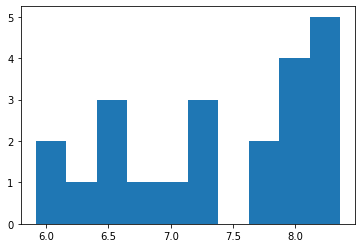

In [232]:
plt.hist(numpy.log(num_genes))

(array([180.,  60.,  90.,   0.,  30.,  60.,  60.,  30.,   0., 150.]),
 array([10.08676333, 10.178087  , 10.26941066, 10.36073433, 10.452058  ,
        10.54338167, 10.63470533, 10.726029  , 10.81735267, 10.90867633,
        11.        ]),
 <BarContainer object of 10 artists>)

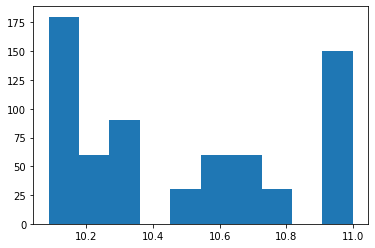

In [233]:
plt.hist(num_genes*30/max(num_genes)+10)

In [234]:
node_text = [f'{labels[i]+1}: {regions_df.name.values[i]}:</br></br> {num_genes[i]}' for i in range(len(cen_scores))]

node_size = (numpy.array(num_genes)*30/max(num_genes))+10

In [236]:
colors = cmap(numpy.linspace(0, 1, max(labels)+1))
colors_hex=[mpl.colors.rgb2hex(l) for l in colors]

fig = go.Figure(data=[edge_trace1,edge_trace2],
             layout=go.Layout(
                title=f'Communities and Number of Cyclic Genes',
                titlefont_size=16,
                showlegend=True,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

for l in range(max(labels)+1):
        #if (l!=0):
        #    continue
        trace_node_x = numpy.array(node_x)[labels==l]
        trace_node_y = numpy.array(node_y)[labels==l]
        trace_text = [node_text[i] for i in range(len(node_x)) if labels[i]==l]
        trace_size = [node_size[i] for i in range(len(node_x)) if labels[i]==l]
        #trace_color = [colors_hex[i] for i in range(len(node_x)) if labels[i]==l]
        
        trace_color = colors_hex[l]
        fig.add_trace(go.Scatter(
            y=trace_node_y,
            x=trace_node_x,
            mode='markers',
            marker_color=trace_color,
            marker_size=trace_size,
            marker_opacity=0.5,
            text=trace_text,
            hoverinfo="text",
            marker_line_color='black',
            marker_line_width=0.1
        ))
        

for i,roi in enumerate(regions):
    roi_idx = list(node_input).index(roi)
    coord_x = node_x[roi_idx]
    coord_y = node_y[roi_idx]
    fig.add_annotation(x=coord_x, y=coord_y,
                        text=roi,
                        showarrow=False)


plotly.io.write_html(fig, file=f'figures/cyclicgenes-louvain.html')
plotly.io.write_image(fig, file=f'figures/cyclicgenes-louvain.png')
plotly.io.write_image(fig, file=f'figures/cyclicgenes-louvain.svg')

fig.show()

In [238]:
colors = [numpy.array(cl)/255 for cl in allen_colors]
colors_hex=[mpl.colors.rgb2hex(l) for l in colors]

fig = go.Figure(data=[edge_trace1,edge_trace2],
             layout=go.Layout(
                title=f'Allen Structure and Num Cyclic Genes',
                titlefont_size=16,
                showlegend=True,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

for l in range(max(labels)+1):
        #if (l!=0):
        #    continue
        trace_node_x = numpy.array(node_x)[labels==l]
        trace_node_y = numpy.array(node_y)[labels==l]
        trace_text = [node_text[i] for i in range(len(node_x)) if labels[i]==l]
        trace_size = [node_size[i] for i in range(len(node_x)) if labels[i]==l]
        trace_color = [colors_hex[i] for i in range(len(node_x)) if labels[i]==l]
        
        #trace_color = colors_hex[l]
        fig.add_trace(go.Scatter(
            y=trace_node_y,
            x=trace_node_x,
            mode='markers',
            marker_color=trace_color,
            marker_size=trace_size,
            marker_opacity=0.5,
            text=trace_text,
            hoverinfo="text",
            marker_line_color='black',
            marker_line_width=0.1
        ))
        

for i,roi in enumerate(regions):
    roi_idx = list(node_input).index(roi)
    coord_x = node_x[roi_idx]
    coord_y = node_y[roi_idx]
    fig.add_annotation(x=coord_x, y=coord_y,
                        text=roi,
                        showarrow=False)


plotly.io.write_html(fig, file=f'figures/cyclicgenes-allen.html')
plotly.io.write_image(fig, file=f'figures/cyclicgenes-allen.png')
plotly.io.write_image(fig, file=f'figures/cyclicgenes-allen.svg')

fig.show()

In [239]:
gene_comps = []
for l in range(max(labels)+1):
    gene_comps.append([num_genes[i] for i in range(len(regions)) if labels[i]==l])

In [242]:
import scipy

In [249]:
len(num_genes)

22

In [248]:
gene_comps[2]

[674, 1455, 1457, 1504, 2755, 2813]

In [275]:
ts = []
ps = []
for (i,j) in itertools.combinations(range(3),2):
    t,p = scipy.stats.ttest_ind(gene_comps[i],gene_comps[j])
    print(f'{i} and {j}: {p}')
    ps.append(p)
ps

0 and 1: 0.08023935523245324
0 and 2: 0.8382163081190628
1 and 2: 0.12276378911150537


[0.08023935523245324, 0.8382163081190628, 0.12276378911150537]

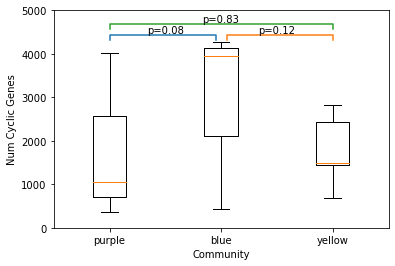

In [250]:
box = plt.boxplot(gene_comps)

y, h0, h = max(max(gene_comps[0]),max(gene_comps[1])), 50, 150
plt.plot([1,1,1.95,1.95],[y+h0,y+h,y+h,y+h0], lw=1.5)
plt.text(1.5,y+h+50,"p=0.08",ha="center")
    
    
y, h0, h = max(max(gene_comps[1]),max(gene_comps[2])), 50, 150
plt.plot([2.05,2.05,3,3],[y+h0,y+h,y+h,y+h0], lw=1.5)
plt.text(2.5,y+h+50,"p=0.12",ha="center")


y, h0, h = max(max(gene_comps[0]),max(gene_comps[1]),max(gene_comps[2])), 300, 400
plt.plot([1,1,3,3],[y+h0,y+h,y+h,y+h0], lw=1.5)
plt.text(2,y+h+50,"p=0.83",ha="center")

plt.ylim([0,5000])
plt.xlabel("Community")
plt.ylabel("Num Cyclic Genes")


plt.xticks([1,2,3],['purple','blue','yellow'])
plt.savefig("figures/cyclic-gene-comp_clusters.png")
plt.savefig("figures/cyclic-gene-comp_clusters.svg")

(array([13.,  2.,  2.,  2.,  0.,  0.,  0.,  1.,  1.,  1.]),
 array([0.        , 0.01404762, 0.02809524, 0.04214286, 0.05619048,
        0.0702381 , 0.08428571, 0.09833333, 0.11238095, 0.12642857,
        0.14047619]),
 <BarContainer object of 10 artists>)

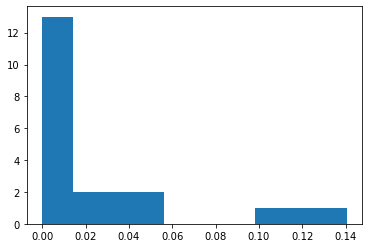

In [251]:
plt.hist(cen_scores)

(array([6., 2., 3., 0., 1., 2., 2., 1., 0., 5.]),
 array([ 371. ,  761.5, 1152. , 1542.5, 1933. , 2323.5, 2714. , 3104.5,
        3495. , 3885.5, 4276. ]),
 <BarContainer object of 10 artists>)

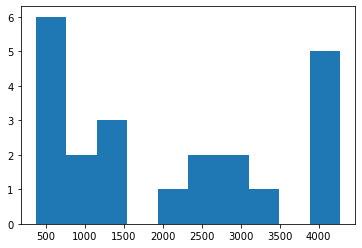

In [252]:
plt.hist(num_genes)

In [253]:
import statsmodels.api as sm

In [254]:
X = sm.add_constant(cen_scores)
model = sm.OLS(num_genes,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.7504
Date:                Tue, 25 Apr 2023   Prob (F-statistic):              0.397
Time:                        15:14:19   Log-Likelihood:                -189.52
No. Observations:                  22   AIC:                             383.0
Df Residuals:                      20   BIC:                             385.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1954.0437    354.742      5.508      0.000    1214.065    2694.022
x1          6201.8397   7159.327      0.866      0.397   -8732.255    2.11e+04
==============================================================================
Omnibus:                        5.506   Durbin-Watson:                   2.236
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                1.972
Skew:                           0.329   Prob(JB):                        0.373
Kurtosis:                       1.690   Cond. No.                         24.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [255]:
results.params

array([1954.04369666, 6201.83968888])

In [256]:
results.pvalues

array([2.16128955e-05, 3.96620995e-01])

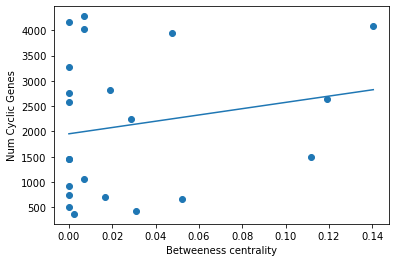

In [257]:
par = numpy.polyfit(cen_scores,num_genes,1,full=True)
m = results.params[1]
b = results.params[0]

xs = numpy.linspace(min(cen_scores),max(cen_scores),150)
ys = m*xs+b

plt.scatter(cen_scores,num_genes)
plt.plot(xs,ys)
plt.xlabel("Betweeness centrality")
plt.ylabel("Num Cyclic Genes")
plt.savefig("figures/centrality-vs-cyclic-genes.png")
plt.savefig("figures/centrality-vs-cyclic-genes.svg")

In [258]:
scipy.stats.pearsonr(cen_scores,num_genes)

(0.1901669407986451, 0.39662099522856153)

# look at cyclic gene overlap

In [262]:
projections = []
shared_genes = []

for i,r1 in enumerate(regions):
    for j,r2 in enumerate(regions):
        if i != j:
            projections.append(con_scale_m[i,j])
            shared_genes.append(cyclic_genes_df.loc[r1]
                               [r2])


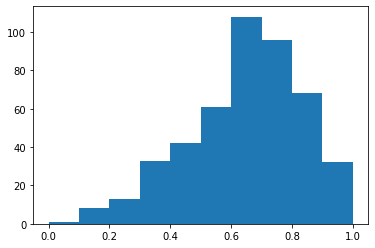

In [263]:
plt.hist(projections);

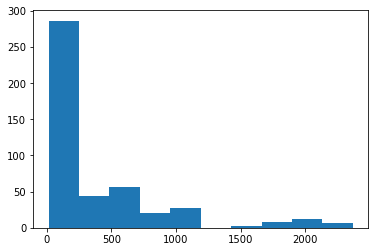

In [264]:
plt.hist(shared_genes);

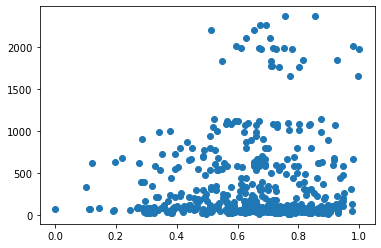

In [265]:
plt.scatter(projections,shared_genes)

In [271]:
scipy.stats.pearsonr(projections,shared_genes)

(0.08209059865246629, 0.07795674198955664)

In [270]:
X = sm.add_constant(projections)
model = sm.OLS(shared_genes,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.121
Date:                Tue, 25 Apr 2023   Prob (F-statistic):             0.0780
Time:                        15:50:33   Log-Likelihood:                -3531.8
No. Observations:                 462   AIC:                             7068.
Df Residuals:                     460   BIC:                             7076.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        238.5873     85.215      2.800      0.005      71.129     406.045
x1           223.7022    126.628      1.767      0.078     -25.139     472.543
==============================================================================
Omnibus:                      189.488   Durbin-Watson:                   1.532
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              575.728
Skew:                           2.003   Prob(JB):                    9.60e-126
Kurtosis:                       6.722   Cond. No.                         7.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

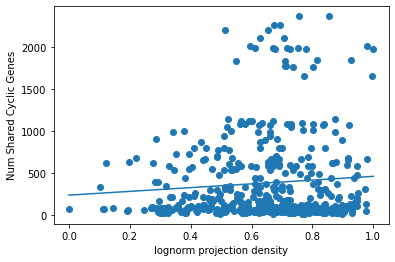

In [276]:
m = results.params[1]
b = results.params[0]

xs = numpy.linspace(0,1,150)
ys = m*xs+b

plt.scatter(projections,shared_genes)
plt.plot(xs,ys)
plt.xlabel("lognorm projection density")
plt.ylabel("Num Shared Cyclic Genes")
plt.savefig("figures/projections-vs-shared-cyclic-genes.png")
plt.savefig("figures/projections-vs-shared-cyclic-genes.svg")